In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from proj1_helpers import *
#from implementations import *
DATA_FOLDER = '../data/'

In [3]:
from split_data import split_data

In [4]:
from implementations import *
from loss import *

In [5]:
y_train, x_train, id_train = load_csv_data(DATA_FOLDER + 'train.csv')
y_test, x_test, id_test = load_csv_data(DATA_FOLDER + 'test.csv')

In [6]:
y_train

array([ 1., -1., -1., ...,  1., -1., -1.])

### Basic Least Squares

In [7]:
def compare_prediction(w_train, x, y):
    y_pred = predict_labels(w_train, x)
    return (y_pred == y).sum()/len(y_pred)

In [167]:
w_ls, loss_ls = least_squares(y_train, x_train)
compare_prediction(w_ls, x_train, y_train)

0.74432799999999999

In [306]:
x_poly = build_poly(x_train[:2000], 4)
w_ls, loss_ls = least_squares(y_train[:2000], x_poly)
compare_prediction(w_ls, x_poly, y_train[:2000])

LinAlgError: Singular matrix

### Stochastic Gradient Descent

In [9]:
initial_w = np.asarray([1]*30)
max_iters = 30
gamma = 0.7

In [10]:
w_sgd, loss_sgd = least_squares_SGD(y_train, x_train, initial_w, max_iters, gamma)

C:\ML_project\project1\template\loss.py:5: RuntimeWarning: overflow encountered in square
  return np.mean(e**2)/2.


In [11]:
compare_prediction(w_sgd, x_train, y_train)

0.63045200000000001

### Ridge Regression

In [14]:
from build_polynomial import build_poly

def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    # split data
    x_tr, y_tr, x_te, y_te = split_data(x, y, ratio, seed)
    
    tr_poly = build_poly(x_tr, degree)
    te_poly = build_poly(x_te, degree)
    
    #loss = 1000
    best_comp_pred = 0
    w = 0
    
    for lambda_ in lambdas:
        # ridge regression
        weight, l = ridge_regression(y_tr, tr_poly, lambda_, 1)
        #weight = stack_w(weight, degree)
        mse_test = compute_loss(y_te, te_poly, weight)
        
        comp_pred = compare_prediction(weight.reshape(len(weight), 1), tr_poly, y_tr.reshape(len(y_tr), 1))
        if(comp_pred > best_comp_pred):
            best_comp_pred = comp_pred
            print(best_comp_pred)
            loss = mse_test
            w = weight
        
    return w, loss

In [240]:
# boucler sur les seeds pour avoir un meileur ? 
#seed = 95
#degree = 6
#split_ratio = 0.29

seed = 120
degree = 6
split_ratio = 0.9

w_r, loss_ridge = ridge_regression_demo(x_train, y_train, degree, split_ratio, seed)

0.799782222222
0.800048888889


In [241]:
compare_prediction(w_r.reshape(len(w_r), 1), build_poly(x_train, degree), y_train.reshape(len(y_train), 1))

0.799736

### Cross-validation

In [183]:
from build_k_indices import build_k_indices
from implementations import ridge_regression
from build_polynomial import build_poly

def cross_validation(func, y, x, k_indices, k, lambda_, degree, gamma):
    """return the loss of ridge regression."""

    # get k'th subgroup in test, others in train
    train_indices = [x for j, x in enumerate(k_indices) if j != k]
    train_indices = [idx for part in train_indices for idx in part]
    test_indices = k_indices[k]
    
    x_tr = x[train_indices]
    y_tr = y[train_indices]
    
    x_te = x[test_indices]
    y_te = y[test_indices]

    # form data with polynomial degree
    train_poly = build_poly(x_tr, degree)
    test_poly = build_poly(x_te, degree)

    # ridge regression
    weights_train, loss_tr = func(y_tr, train_poly, lambda_, gamma)

    # calculate the loss for train and test data
    loss_te = compute_loss(y_te, test_poly, weights_train)

    return loss_tr, loss_te, weights_train

In [184]:
def cross_valid_vizu(values, name, rmse_tr, rmse_te):
    """visualization the curves of mse_tr and mse_te."""
    plt.semilogx(values, rmse_tr, marker=".", color='b', label='train error')
    plt.semilogx(values, rmse_te, marker=".", color='r', label='test error')
    plt.xlabel(name)
    plt.ylabel("rmse")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    plt.savefig("cross_validation")

In [276]:
def cross_validation_demo(func, lambdas, degrees, gammas, k_fold):
    
    seed = 1
    # split data in k fold
    k_indices = build_k_indices(y_train[:4000], k_fold, seed)
    
    best_l = 0 
    best_deg = 0
    best_g = 0
    min_loss = 1000
    best_pred = 0
     # define list to store the variable
    rmse_tr = np.empty((len(lambdas), len(degrees), len(gammas)))
    rmse_te = np.empty((len(lambdas), len(degrees), len(gammas)))
    
    for ind_l, l in enumerate(lambdas):
        print(ind_l)
        for ind_deg, deg in enumerate(degrees):
            for ind_g, g in enumerate(gammas):
                sum_loss_tr = 0
                sum_loss_te = 0
                for k_test in range(k_fold):
                    loss_tr, loss_te, we = cross_validation(func, y_train[:100000], x_train[:100000], k_indices, k_test, l, deg, g)
                    sum_loss_tr = sum_loss_tr + loss_tr
                    sum_loss_te = sum_loss_te + loss_te
                rmse_t = np.sqrt(2*sum_loss_te)
                rmse_tr[ind_l][ind_deg][ind_g] = np.sqrt(2*sum_loss_tr)
                rmse_te[ind_l][ind_deg][ind_g] = rmse_t
                
                #pred = compare_prediction(we, build_poly(x_train, deg), y_train)
                #if(pred > best_pred):
                #    best_pred = pred
                if(rmse_t < min_loss):
                    min_loss = rmse_t
                    best_l = l
                    best_deg = deg
                    best_g = g
    print(np.argmin(rmse_te))
    print(np.shape(rmse_tr[:, 0, 0]))
    cross_valid_vizu(lambdas, 'lambdas', rmse_tr[:, 0, 0], rmse_te[:, 0, 0])
    return best_l, best_deg, best_g

In [289]:
    seed = 69
    degree = 2
    degrees = range(6, 7)
    k_fold = 4
    lambdas = [1]#np.logspace(-5, 0, 30)
    gammas_ridge = [1]

In [290]:
bl

2.2122162910704501e-05

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
2
(30,)


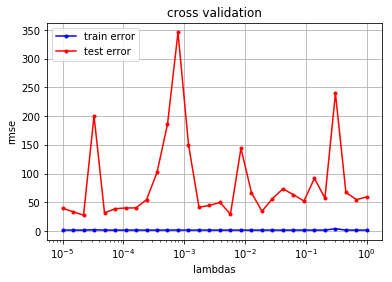

In [291]:
bl, bd, bg = cross_validation_demo(ridge_regression, lambdas, degrees, gammas_ridge, k_fold)

In [292]:
bl

2.2122162910704501e-05

In [299]:
x_poly = build_poly(x_train, 6)
epsylon = 10.**(-4)

In [300]:
w, l = ridge_regression(y_train, x_poly, bl, 1)
compare_prediction(w, x_poly, y_train)

0.79975200000000002

In [301]:
w, l = ridge_regression(y_train, x_poly, bl+epsylon, 1)
compare_prediction(w, x_poly, y_train)

0.79975200000000002

In [302]:
w, l = ridge_regression(y_train, x_poly, bl-epsylon, 1)
compare_prediction(w, x_poly, y_train)

0.79969999999999997

### Logistic Regression

In [ ]:
def cross_validation_logi(y, x, k_indices, k, lambda_, degree, gamma):
    """return the loss of ridge regression."""

    # get k'th subgroup in test, others in train
    train_indices = [x for j, x in enumerate(k_indices) if j != k]
    train_indices = [idx for part in train_indices for idx in part]
    test_indices = k_indices[k]
    
    x_tr = x[train_indices]
    y_tr = y[train_indices]
    
    x_te = x[test_indices]
    y_te = y[test_indices]

    # form data with polynomial degree
    train_poly = build_poly(x_tr, degree)
    test_poly = build_poly(x_te, degree)

    # ridge regression
    weights_train, loss_tr = logistic_regression(y_tr, train_poly, lambda_, gamma)

    # calculate the loss for train and test data
    loss_te = compute_loss(y_te, test_poly, weights_train)

    return loss_tr, loss_te, weights_train

In [ ]:
def cross_validation_logi_demo(lambdas, degrees, gammas, k_fold):
    
    seed = 1
    # split data in k fold
    k_indices = build_k_indices(y_train[:4000], k_fold, seed)
    
    best_l = 0 
    best_deg = 0
    best_g = 0
    min_loss = 1000
    best_pred = 0
     # define list to store the variable
    rmse_tr = np.empty((len(lambdas), len(degrees), len(gammas)))
    rmse_te = np.empty((len(lambdas), len(degrees), len(gammas)))
    
    for ind_l, l in enumerate(lambdas):
        print(ind_l)
        for ind_deg, deg in enumerate(degrees):
            for ind_g, g in enumerate(gammas):
                sum_loss_tr = 0
                sum_loss_te = 0
                for k_test in range(k_fold):
                    loss_tr, loss_te, we = cross_validation_logi(y_train[:100000],  \
                                                            x_train[:100000], k_indices, k_test, l, deg, g)
                    sum_loss_tr = sum_loss_tr + loss_tr
                    sum_loss_te = sum_loss_te + loss_te
                rmse_t = np.sqrt(2*sum_loss_te)
                rmse_tr[ind_l][ind_deg][ind_g] = np.sqrt(2*sum_loss_tr)
                rmse_te[ind_l][ind_deg][ind_g] = rmse_t
                
                #pred = compare_prediction(we, build_poly(x_train, deg), y_train)
                #if(pred > best_pred):
                #    best_pred = pred
                if(rmse_t < min_loss):
                    min_loss = rmse_t
                    best_l = l
                    best_deg = deg
                    best_g = g
                    
    cross_valid_vizu(lambdas, 'lambdas', rmse_tr[:, 0, 0], rmse_te[:, 0, 0])
    return best_l, best_deg, best_g

In [ ]:
 degrees = range(6, 7)
    k_fold = 4
    lambdas = [1]#np.logspace(-5, 0, 30)
    gammas_ridge = [1]#np.logspace(-15, 0, 30)

In [ ]:
bl, bd, bg = cross_validation_logi_demo(lambdas, degrees, gammas_ridge, k_fold)

### END CROSS_VALID

In [ ]:
def sigmoid(t):
    """apply sigmoid function on t."""
    sig = 2*(np.exp(t) / (1 + np.exp(t))) - 1
    #sig = (np.exp((t+1)/2) / (np.exp((t+1)/2)+1)
    return sig

In [ ]:
def calculate_gradient(y, tx, w):
    """compute the gradient of loss."""
    
    return  tx.T @(sigmoid(tx @ w) - y)

In [ ]:
def learning_by_gradient_descent(y, tx, w, gamma):
    """
    Do one step of gradient descen using logistic regression.
    Return the loss and the updated w.
    """
    loss = calculate_loss(y, tx, w)
    grad = calculate_gradient(y, tx, w)
    w = w - gamma * grad
    return loss, w

In [ ]:
def shuffle_index_resize(y,x, max_elem_percent):
    y_pos = []
    y_neg = []
    
    max_elem = int(((max_elem_percent * len(y) ) / 100) / 2.0)

    for idx_y, val in enumerate(y):

        if(val == 1):
            y_pos.append(idx_y)
        else:
            y_neg.append(idx_y)

        
    data_size_pos = len(y_pos)  
    shuffle_indices_pos = np.random.permutation(np.arange(data_size_pos)) 
    data_size_neg = len(y_neg)  
    shuffle_indices_neg = np.random.permutation(np.arange(data_size_neg)) 
    new_y = []
    new_x = []
    for i in range(max_elem):
        new_y.append(y[y_pos[shuffle_indices_pos[i]]])
        new_y.append(y[y_neg[shuffle_indices_neg[i]]])
        new_x.append(x[y_pos[shuffle_indices_pos[i]]])
        new_x.append(x[y_neg[shuffle_indices_neg[i]]])
    
    return np.array(new_y), np.array(new_x)


new_y, new_x = shuffle_index_resize(y_train, x_train, 0.2)

np.shape(new_x)

In [ ]:
def logistic_regression_gradient(y, x, w, gamma, max_iter):
    # init parameters
    #max_iter = 100000
    threshold = 1e-8
    #gamma = 0.000000001
    lambda_ = 0.02
    losses = []

    # build tx
    #tx = np.c_[np.ones((y.shape[0], 1)), x]
    #w = np.zeros((tx.shape[1], 1))
    
    # start the logistic regression
    for iter_ in range(max_iter):
        # get loss and update w.
        
        #y, x = shuffle_index_resize2(y, x, 50000); #100000 = 40%  12500 = 5%
        
        if((iter_ % 1000) == 0):
            print(iter_)
        loss, w = learning_by_gradient_descent(y, x, w, gamma)
        
        #loss, w = learning_by_newton_method(y, tx, w)
        #loss, w = learning_by_penalized_gradient(y, tx, w, gamma, lambda_)
    return loss, w

#nb = 200

#x_train2 = x_train[:nb]

#y_train2 = y_train.reshape(len(y_train), 1)
#y_train2 = y_train2[:nb]
#loss, w = logistic_regression_gradient_descent_demo(y_train2, x_train2)
#loss

In [ ]:
def test():
    #gammas = np.arange(0.48e-13,0.51e-13,1e-15)
    gammas = np.logspace(-15, 0, 30)
    # last = 5.5e-12

    max_iter = 5000
    #max_iter = 100000

    best_compare_pred = 0
    best_gamma = 0
    best_w = 0


    #y_train2, x_train2 = shuffle_index_resize(y_train,x_train, 68)
    x_train2 = x_train
    y_train2 = y_train

    y_train2 = y_train2.reshape(len(y_train2), 1)
    #print(np.shape(y_train2))
    #print(np.shape(x_train2))


    tx = np.c_[np.ones((y_train2.shape[0], 1)), x_train2]
    w_init = np.zeros((tx.shape[1], 1))

    #print(np.shape(w_init))

    gamma_step = len(gammas)

    for gamma_ in gammas:
    
        loss, w = logistic_regression_gradient(y_train2, tx, w_init, gamma_, max_iter)
    
        #print(np.shape(w))
        gamma_step -= 1;
        print('%d steps' % gamma_step)
        print(gamma_)
    
        compare_pred = compare_prediction(w, tx, y_train2)
        print('compare_pred  = ' + str(compare_pred) + ', best_compare_pred = '+ str(best_compare_pred))
      
        if(compare_pred > best_compare_pred):
            print('compare_pred = %f' % compare_pred)
            best_compare_pred = compare_pred;
            best_gamma = gamma_;
            best_w = w;
        
    return best_compare_pred, best_gamma, best_w 

In [ ]:
best_compare_pred, best_gamma, best_w  = test()
print(best_compare_pred)
print(best_gamma)
print(np.shape(best_w))

In [ ]:
compare_prediction(best_w, tx, y_train2)

In [ ]:
best_w_saved = best_w
best_gamma_saved = best_gamma
best_loss_saved = best_loss

In [ ]:
np.shape(new_y)

In [ ]:
def penalized_logistic_regression(y, tx, w, lambda_):
    """return the loss, gradient, and hessian."""
    # return loss, gradient, and hessian
    #loss = calculate_loss(y, tx, w) + (w.T@w*lambda_ / 2.0)
    
    grad = calculate_gradient(y, tx, w) + (w*lambda_)
    
    return grad

In [ ]:
def learning_by_penalized_gradient(y, tx, w, gamma, lambda_):
    """
    Do one step of gradient descent, using the penalized logistic regression.
    Return the loss and updated w.
    """
    gradient = penalized_logistic_regression(y, tx, w, lambda_)
    w -= gamma * gradient
    return w

In [ ]:
def shuffle_index_resize2(y,x, max_elem_percent):
    y_pos = []
    y_neg = []
    
    max_elem = int(max_elem_percent / 2)

    for idx_y, val in enumerate(y):

        if(val == 1):
            y_pos.append(idx_y)
        else:
            y_neg.append(idx_y)

        
    data_size_pos = len(y_pos)  
    shuffle_indices_pos = np.random.permutation(np.arange(data_size_pos)) 
    data_size_neg = len(y_neg)  
    shuffle_indices_neg = np.random.permutation(np.arange(data_size_neg)) 
    new_y = []
    new_x = []
    for i in range(max_elem):
        new_y.append(y[y_pos[shuffle_indices_pos[i]]])
        new_y.append(y[y_neg[shuffle_indices_neg[i]]])
        new_x.append(x[y_pos[shuffle_indices_pos[i]]])
        new_x.append(x[y_neg[shuffle_indices_neg[i]]])
    
    return np.array(new_y), np.array(new_x)


new_y, new_x = shuffle_index_resize2(y_train, x_train, 0.2)

np.shape(new_x)

In [ ]:
def logistic_regression_gradient_descent_demo(y, x, w, gamma, max_iter, lambda_):
    # init parameters
    #max_iter = 100000
    #gamma = 0.000000001
    #lambda_ = 0.02
    threshold = 1e-8
    losses = []
        
    # build tx
    #tx = np.c_[np.ones((y.shape[0], 1)), x]
    #w = np.zeros((tx.shape[1], 1))
    
    
    # start the logistic regression
    for iter_ in range(max_iter):
        # get loss and update w.
        
        y, x = shuffle_index_resize2(y, x, 50000); #100000 = 40%  12500 = 5%
        
        if((iter_ % 100) == 0):
            print(iter_)
        w = learning_by_penalized_gradient(y, x, w, gamma, lambda_)
        
        #losses.append(loss)
        #if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            #break
        
        #loss, w = learning_by_newton_method(y, tx, w)
        #loss, w = learning_by_penalized_gradient(y, tx, w, gamma, lambda_)
    return w




In [ ]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    
    # problem ici avec 1 et sum
    phi_x = []
    
    for j in range(0, degree + 1):
        if(j == 0):
            phi_x = np.power(x, j)
        else:
            x_power_j = np.power(x, j)
            phi_x = np.c_[phi_x, x_power_j]

    return phi_x

In [ ]:
gammas = np.logspace(-15, -10, 5)
#gammas = np.arange(0.48e-13,1.0e-13,1e-15)
# last = 7.19685673001e-12  1e-13

max_iter = 400
#max_iter = 100000

lambdas = np.logspace(-20, -15, 5)
#lambdas = np.logspace(-13, -10, 2)
#lambdas = np.arange(1.9e-9,2.1e-9,1e-10)
# last =

best_comp_pred = 0
best_gamma = 0
best_w = 0
best_lambda = 0


#degree = 4
#x_train2 = build_poly(x_train, degree)
x_train2 = x_train
y_train2 = y_train
#y_train2, x_train2 = shuffle_index_resize(y_train,x_train, 60)

y_train2 = y_train2.reshape(len(y_train2), 1)

tx = np.c_[np.ones((y_train2.shape[0], 1)), x_train2]
w_init = np.zeros((tx.shape[1], 1))

gamma_step = len(gammas)

for gamma_ in gammas:
    lambda_step = len(lambdas)
    
    for lambda_ in lambdas:
        w = logistic_regression_gradient_descent_demo(y_train2, tx, w_init, gamma_, max_iter, lambda_)
        
        #comp_pred = compare_prediction(weight.reshape(len(weight), 1), tr_poly, y_tr.reshape(len(y_tr), 1))
        
        #loss, w = logistic_regression_gradient_descent_demo(y_train2, tx, w_init, gamma_, max_iter, lambda_)
        print('degree')
        #compare_prediction(w_r.reshape(len(w_r), 1), build_poly(x_train, degree), y_train.reshape(len(y_train), 1))

        comp_pred = compare_prediction(w, tx, y_train2)
        print('comp_pred  = ' + str(comp_pred) + ', best_comp_pred = '+ str(best_comp_pred))
        
        if(comp_pred > best_comp_pred):
            print('comp_pred = %f' % comp_pred)
            best_comp_pred = comp_pred;
            best_gamma = gamma_;
            best_w = w;
            best_lambda = lambda_
            
        lambda_step -= 1;
        print('%d steps_lambda' % lambda_step)
        print('lambda')
        print(lambda_)
        
        #comp_pred = compare_prediction(w, tx, y_train2)
        #print('comp_pred  = ' + str(comp_pred) + ', best_comp_pred = '+ str(best_comp_pred))
        
        #if(comp_pred > best_comp_pred):
            #print('comp_pred = %f' % comp_pred)
            #best_comp_pred = comp_pred;
            #best_gamma = gamma_;
            #best_w = w;
            #best_lambda = lambda_
    
    #print(np.shape(w))
    gamma_step -= 1;
    print('%d steps_gamma' % gamma_step)
    print('gamma')
    print(gamma_)
        
best_loss    

In [ ]:
print(best_loss)
print(best_gamma)
np.shape(best_w)

In [ ]:
compare_prediction(best_w, tx, y_train2)

In [ ]:
best_w2_saved = best_w
best_gamma2_saved = best_gamma
best_loss2_saved = best_loss

In [ ]:
def cross_validation(y, x, k_indices, k, lambda_, gamma_, max_iter):
    """return the loss of ridge regression."""

    # get k'th subgroup in test, others in train
    train_indices = [x for j, x in enumerate(k_indices) if j != k]
    train_indices = [idx for part in train_indices for idx in part]
    test_indices = k_indices[k]
    
    x_train = x[train_indices]
    y_train = y[train_indices]
    
    y_train2 = y_train.reshape(len(y_train), 1)

    x_train2 = np.c_[np.ones((y_train2.shape[0], 1)), x_train]
    w_init = np.zeros((tx.shape[1], 1))
    
    # Logistic regression
    
    #print(np.shape(y_train2))
    #print(np.shape(x_train2))
    
    #weights_train, loss_tr = ridge_regression(y_train, train_poly, lambda_)
    loss_tr, weights_train = logistic_regression_gradient_descent_demo(y_train2, x_train2, w_init, gamma_, max_iter, lambda_)
    
    return loss_tr

In [ ]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [ ]:
def cross_validation_demo():
    seed = 1
    k_fold = 2
    max_iter = 400
    lambdas = np.logspace(-13, 0, 15)
    gammas = np.logspace(-13, 0, 15)
    
    # split data in k fold
    k_indices = build_k_indices(y_train, k_fold, seed)
    
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    
    best_loss_train = 100000
    best_gamma = 0
    best_lambda = 0
    #best_w = 0
    
    gamma_step = len(gammas)
    
    # cross validation
    for gamma_ in gammas:
        loss_tr_tmp = []
        lambda_step = len(lambdas)
        
        for lambda_ in lambdas: 
            
            for i_test in range(k_fold): 
                loss_tr = cross_validation(y_train, x_train, k_indices, i_test, lambda_, gamma_, max_iter)
                loss_tr_tmp.append(loss_tr)
                print('loss  = ' + str(loss) + ', best_loss = '+ str(best_loss_train))
            
            lambda_step -= 1;
            print('%d steps_lambda' % lambda_step)
            print('lambda')
            print(lambda_)
            print('loss_mean')
            print(np.sqrt(2*np.mean(loss_tr_tmp)))
            
            #compare_pred = compare_prediction(best_w, tx, y_train2)
            
            loss_train = np.sqrt(2*np.mean(loss_tr_tmp))
            
            if(loss_train < best_loss_train):
                
                best_loss_train = loss_train
                best_gamma = gamma_
                best_lambda = lambda_
                #best_w = w  
        gamma_step -= 1;
        print('%d steps_gamma' % gamma_step)
        print('gamma')
        print(gamma_)

cross_validation_demo()

In [ ]:
print(best_loss)
print(best_gamma)
np.shape(best_w)

In [ ]:
y_train2 = y_train.reshape(len(y_train), 1)
tx = np.c_[np.ones((y_train2.shape[0], 1)), x_train]

compare_prediction(best_w, tx, y_train2)